---
title: LLMs/PyTorch Basics and Recipes
description: Key things to be able to do with LLMs (PyTorch/HF/Llamaindex)
date: 2024-09
categories: [PyTorch]
---

## PyTorch Basics

### Batch Normalization
- If affine, initialize gamma and beta
- Initialize running mean and variance buffers
- Get mean/var over nonchannel dimensions
- Update running mean and variance statistics using momentum running average without tracking gradients
- If training, use the computed mean/var; else use running mean/var
- Normalize the input
- Apply gamma and beta if they're there (affine)
- Return normalized input

In [ ]:

import torch
import torch.nn as nn

class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True):
        super(BatchNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        # Learnable affine parameters: gamma (scale) and beta (shift)
        self.gamma, self.beta = None, None
        if affine:
            self.gamma = nn.Parameter(torch.ones(num_features))  # scale parameter
            self.beta = nn.Parameter(torch.zeros(num_features))  # shift parameter

        # Running statistics for mean and variance
        self.running_mean = torch.zeros(num_features) # mean 0
        self.running_var = torch.ones(num_features)   # var 1

    def forward(self, x):
        # Calculate mean and variance across the batch and spatial dimensions (H, W)
        batch_mean = x.mean(dim=(0, 2, 3), keepdim=True)  # mean across N, H, W for each channel
        batch_var = x.var(dim=(0, 2, 3), unbiased=False, keepdim=True)  # variance across N, H, W for each channel

        # Update running statistics (mean and variance): See batch_mean dimension note below
        with torch.no_grad(): # running mean/var are updated via moving avg approach, not SGD
          self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean.squeeze()
          self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var.squeeze()

        # During training, we use the batch statistics
        if self.training:
            mean = batch_mean
            var = batch_var
        else:
            # During inference, we use the running statistics
            mean = self.running_mean.view(1, self.num_features, 1, 1)
            var = self.running_var.view(1, self.num_features, 1, 1)

        # Normalize the input
        x_normalized = (x - mean) / torch.sqrt(var + self.eps)

        # Apply the affine transformation (scaling and shifting)
        if self.gamma is not None and self.beta is not None:
            x_normalized = self.gamma.view(1, self.num_features, 1, 1) * x_normalized + self.beta.view(1, self.num_features, 1, 1)

        return x_normalized


# Example usage
if __name__ == "__main__":
    # Create random input with shape (batch_size, num_features, height, width)
    x = torch.randn(32, 64, 28, 28)  # batch_size=32, num_features=64 (channels), height=28, width=28

    # Instantiate the BatchNorm2d layer
    batch_norm = BatchNorm2d(num_features=64)

    # Forward pass through the batch norm layer
    output = batch_norm(x)

    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")


- Batch mean dimension: Input is of dimension (batch_size, channels, height, width).  When PyTorch computes the mean over dim=(0,2,3), it keeps dim=1 (channel dimension) intact, collapses the batch dimension into 1 and height+width spacial dimensions into one.  So with 64 channels, the shape of mean over dim=(0,2,3) will be (64=uncollapsed channel,1=collapsed bs,1=collapsed hxw).  Will want to squeeze out the 1's to get (64,)-shaped tensor.
- AK: In batch norm, examples in the batch are coupled mathematically.  Activations will change depending on the given batch since mean and variance statistics would change.  Interestingly, this turns out to be good due to a 'regularizer' effect: each individual example is 'padded out', making it harder for neural net to overfit on any specific example.  Still, bugs can arise and other types of normalization have been proposed.  Nonetheless, batch norm is often the most effective.



### Adam Optimizer

In [ ]:


import torch

class AdamOptimizer:
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8, weight_decay=0):
        """
        Adam optimizer from scratch for PyTorch.

        Args:
            params (iterable): The parameters to optimize (typically model.parameters()).
            lr (float): Learning rate (default 1e-3).
            beta1 (float): Exponential decay rate for first moment estimate (default 0.9).
            beta2 (float): Exponential decay rate for second moment estimate (default 0.999).
            epsilon (float): Term added to the denominator to avoid division by zero (default 1e-8).
            weight_decay (float): Weight decay (L2 penalty) (default 0).
        """
        self.params = list(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay

        # Initialize moment estimates
        self.m = [torch.zeros_like(param) for param in self.params]  # First moment (m)
        self.v = [torch.zeros_like(param) for param in self.params]  # Second moment (v)

        # Time step counter
        self.t = 0

    def step(self):
        """
        Perform a single optimization step.
        """
        self.t += 1

        for i, param in enumerate(self.params):
            if param.grad is None:
                continue

            # Get the gradients for the current parameter
            grad = param.grad

            # Apply weight decay (L2 penalty)
            if self.weight_decay != 0:
                #weighting grad linearly ~ weighting weight quadratically w/ L2
                grad = grad + self.weight_decay * param
            # Update biased first moment estimate
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad

            # Update biased second moment estimate
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * grad**2

            # Bias correction
            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)

            # Update parameters
            param.data -= self.lr * m_hat / (torch.sqrt(v_hat) + self.epsilon)

    def zero_grad(self):
        """
        Reset gradients of all parameters.
        """
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()


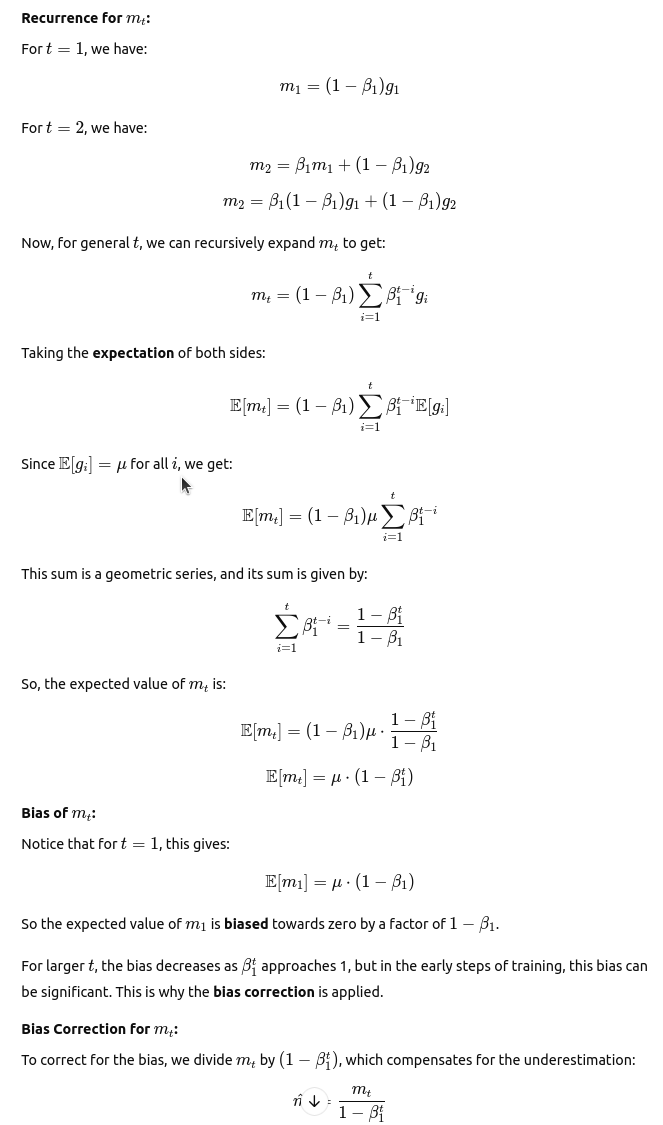

### Dataset and DataLoader

- A custom Dataset class must have `__init__()`,`__len__()`, and `__getitem__()` methods to be used by the data loader.
- Source: Machine Learning with PyTorch and Scikit-Learn by Raschka et al.

In [ ]:
import torch
torch.manual_seed(42)
t_x = torch.rand([4,3],dtype = torch.float32)
t_y = torch.arange(4)

from torch.utils.data import Dataset, DataLoader
class JointDataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
joint_dataset = JointDataset(t_x,t_y)
# alternatively, can create a joint dataset using TensorDataset
# from torch.utils.data import TensorDataset
# tensor_dataset = JointDataset(t_x,t_y)

data_loader = DataLoader(dataset=joint_dataset,batch_size=2,shuffle=True) # will shuffle for every epoch!

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
seq_len = 40
chunk_size = seq_len +1
text_chunks = [text_encoded[i:i+chunk_size] for i in range(len(text_encoded)-chunk_size+1)]

class TextDataset(Dataset):
    def __init__(self, text_chunks):
        self.text_chunks = text_chunks
    def __len__(self):
        return len(self.text_chunks)
    def __getitem__(self, index):
        text_chunk = self.text_chunks[index]
        return text_chunks[:-1].long(), text_chunks[1:].long()
seq_dataset = TextDataset(torch.tensor(text_chunks))
seq_dl = DataLoader(seq_dataset,batch_size=batch_size, shuffle=True, drop_last=True)

### Writing custom layers in PyTorch

In [ ]:
import torch.nn as nn
class NoisyLinear(nn.Module):
    def __init__(self,input_size,output_size,noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w) # will be included in model.parameters() passed to the optimizer
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev
    def forward(self,x,training=False):
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x,noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new,self.w),self.b)
class NoisyModule(nn.Module):
    def __init_(self):
        super().__init__()
        self.l1 = NoisyLinear(2,4,0.07)
        self.a1 = nn.ReLU()
        ...
    def forward(self,x,training=False): 
        x = self.l1(x,training)
        x = self.a1(x)
        ...
    def predict(self,x):
        x = torch.tensor(x,dtype=torch.float32)
        pred = self.forward(x)[:,0] # tra
        return (pred>=0.5).float()
# inside the training loop, use training = True
...
pred = model(x_batch,training=True)[:,0]

### Saving and loading models with PyTorch

#### Option 1: Save the entire model

In [ ]:
torch.save(model, PATH_TO_MODEL)
model = torch.load(PATH_TO_MODEL)

- Not recommended because not only does this save model parameters, it also saves model classes and directory structure of the source code.  If class signatures or directory structures change, may not be able to load the model in the future.

#### Option 2: Save the model parameters

In [ ]:
torch.save(model.state_dict(),PATH_TO_MODEL)
model = ConvNet()
model.load_state_dict(torch.load(PATH_TO_MODEL))
model.eval()

### Building a basic model server and packaging with Docker (from Mastering PyTorch, Second Edition by Jha).

- Inference pipeline (a) the data preprocessing component, (b) the model inference, and (c) the post-processing step.

In [ ]:
# server.py
import os
import json
import numpy as np
from flask import Flask, request

import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)
 
    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op
    
model = ConvNet()
PATH_TO_MODEL = "./convnet.pth"
model.load_state_dict(torch.load(PATH_TO_MODEL, map_location="cpu"))
model.eval()

def run_model(input_tensor):
    model_input = input_tensor.unsqueeze(0)
    with torch.no_grad():
        model_output = model(model_input)[0]
    model_prediction = model_output.detach().numpy().argmax()
    return model_prediction

def post_process(output):
    return str(output)

app = Flask(__name__)

@app.route("/test", methods=["POST"])
def test():
    # 1. Preprocess
    data = request.files['data'].read()
    md = json.load(request.files['metadata'])
    input_array = np.frombuffer(data, dtype=np.float32)
    input_image_tensor = torch.from_numpy(input_array).view(md["dims"])
    # 2. Inference
    output = run_model(input_image_tensor)
    # 3. Postprocess
    final_output = post_process(output)
    return final_output

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=8890)

- Make a request as follows:

In [ ]:
# make_request.py
import io
import json
import requests
from PIL import Image

from torchvision import transforms


image = Image.open("./digit_image.jpg")

def image_to_tensor(image):
    gray_image = transforms.functional.to_grayscale(image)
    resized_image = transforms.functional.resize(gray_image, (28, 28))
    input_image_tensor = transforms.functional.to_tensor(resized_image)
    input_image_tensor_norm = transforms.functional.normalize(input_image_tensor, (0.1302,), (0.3069,))
    return input_image_tensor_norm

image_tensor = image_to_tensor(image)

dimensions = io.StringIO(json.dumps({'dims': list(image_tensor.shape)}))
data = io.BytesIO(bytearray(image_tensor.numpy()))

r = requests.post('http://localhost:8890/test',
                  files={'metadata': dimensions, 'data' : data})

response = json.loads(r.content)

print("Predicted digit :", response)

- Turn into a microservice with the following *Dockerfile*:

In [ ]:
FROM python:3.9-slim

RUN apt-get -q update && apt-get -q install -y wget

COPY ./server.py ./
COPY ./requirements.txt ./

RUN wget -q https://github.com/PacktPublishing/Mastering-PyTorch/raw/master/Chapter10/convnet.pth
RUN wget -q https://github.com/PacktPublishing/Mastering-PyTorch/raw/master/Chapter10/digit_image.jpg

RUN pip install -r requirements.txt


USER root
ENTRYPOINT ["python", "server.py"]

- Build with digit_recognizer tag using current directory as context: `docker build -t digit_recognizer .`
    - Note how server.py and requirements.txt are copied into Docker's directory.  Also USER root may give overly elevated privileges.
- Forward the 8890 port on our machine to 8890 port on the container since app runs on port 8890: `docker run -p 8890:8890 digit_recognizer` 
- Python make_request.py will make a request to the Dockerized Flask model server and we'll get the response.

## Hugging Face

### Tokenizer

- HF Chat Templates

### SFTTrainer

In [ ]:
# ---Step 0: Prepare the data by finding the prompt and formatting a column ('text' for 
# regular SFT, 'messages' for instruction ft, etc), shuffling and splitting it ---
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_config,get_peft_model


model_name = HF_MODEL_ID
# ---Step 1: Initialize BitsAndBytesConfig and feed it to the model upon load---
bnb_config = BitsAndBytesConfig( #Q in QLoRA
    load_in_4bit=True,  # Use 4-bit precision model loading
    bnb_4bit_quant_type="nf4",  # Quantization type
    bnb_4bit_compute_dtype="float16",  # Compute dtype
    bnb_4bit_use_double_quant=True,  # Apply nested quantization
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    # Leave this out for regular SFT
    quantization_config=bnb_config,
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# ---Step 2: Load the tokenizer---
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = "<PAD>"
tokenizer.padding_side = "left"

# ---Step 3: Initialize LoraConfig and i.) peft.prepare_model_for_kbit_training and ii.) peft.get_peft_model---
peft_config = LoraConfig(
    lora_alpha=32,
    lora_dropout=0.1,
    r=128,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=  # Layers to target
     ["k_proj", "gate_proj", "v_proj", "up_proj", "q_proj", "o_proj", "down_proj"]
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

# ---Step 4: Define TrainingArguments, set up SFTTrainer, trainer.train()---
from transformers import DataCollatorForLanguageModeling
training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    num_train_epochs = 10.0,
    logging_steps=10,
    fp16=True,
    gradient_checkpointing=True
)
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset['train'],
    eval_dataset=dataset['valid'],
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
   # peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=256,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=True,
)

trainer.train()
# NOTE: SFTTrainer will automatically send logs to wandb set up via
#  import wandb; wandb.login(); %env WANDB_PROJECT=sql-fine-tuning

# ---Step 5: Save QLoRA weights and merge---
trainer.model.save_pretrained(output_dir)
from peft import AutoPeftModelForCausalLM
model = AutoPeftModelForCausalLM.from_pretrained(output_dir, device_map="auto", torch_dtype=torch.bfloat16)
model = model.merge_and_unload()

output_merged_dir = os.path.join(output_dir, "final_merged_checkpoint")
model.save_pretrained(output_merged_dir, safe_serialization=True)
# NOTE: In the future, can load this final merged model without knowing the QLoRA configurations


# ---Step x: Can use the merged model to make predictions as follows---
from transformers import pipeline

# Use our predefined prompt template
prompt = """<|user|>
Tell me something about Large Language Models.</s>
<|assistant|>
"""

# Run our instruction-tuned model
pipe = pipeline(task="text-generation", model=merged_model, tokenizer=tokenizer)
print(pipe(prompt)[0]["generated_text"])

### Accelerate and Distributed Training

- Notes below are based on [Zack Mueller's](https://parlance-labs.com/education/fine_tuning_course/workshop_2.html) talk
- Distributed Data Parallelism (DDP): full copy of the model exists on every device, but data is chunked between each GPU.
- Fully Sharded Data Parallelism (FSDP) & Deepspeed (DS): Model and optimizer states are split across GPUs -> Two GPUs act as a 'single GPU' for model training.

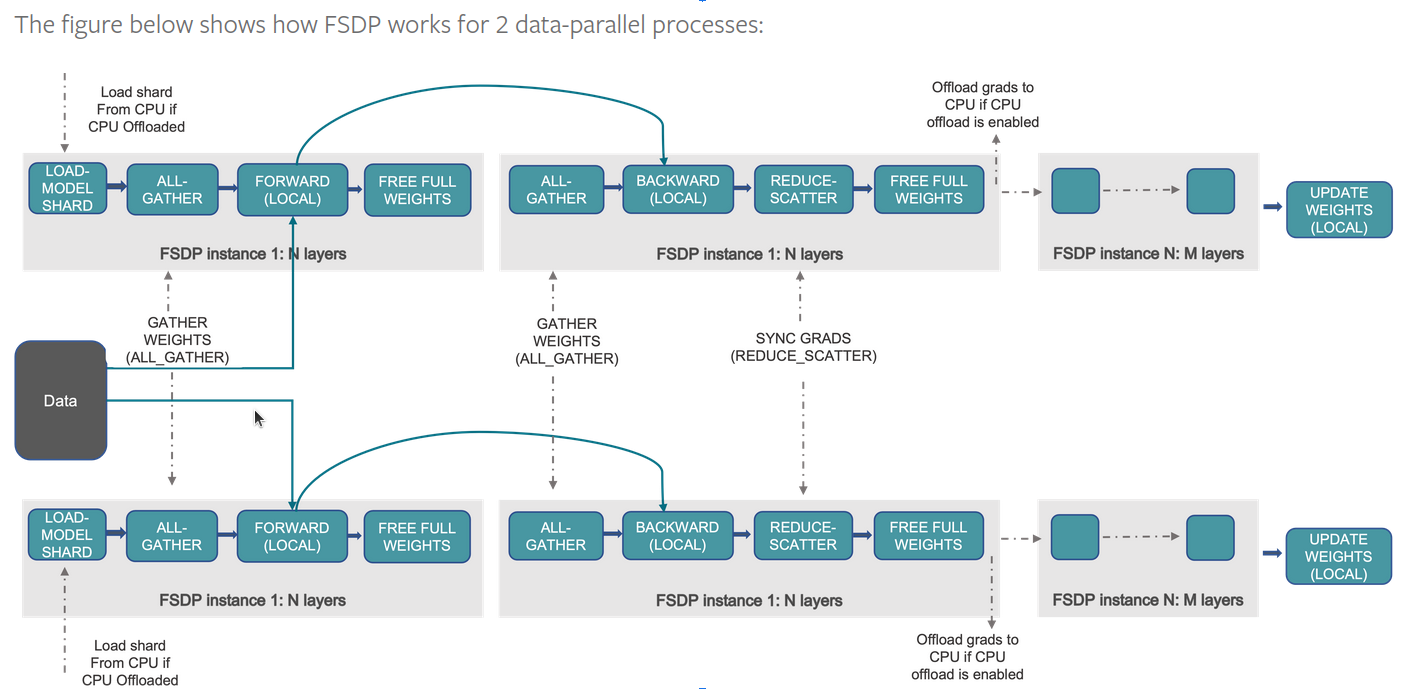

- sharding_strategy
    - FULL_SHARD: optimizer state, gradients, and parameters are sharded
    - SHARD_GRAD_OP: shards optimizer states and gradients; model is split during forward pass, joined during backward pass. Reduces training vRAM a little.
    - NO_SHARD: Normal DDP
    - HYBRID_SHARD: includes optimizer states, gradients, and parameters but each node has the full model.  Reduces multi-node communication.
- offload_params
    - `fsdp_offload_params` allows gradients and model parameters to be offloaded into RAM.  Can train much bigger model, but can be very slow.

- See https://huggingface.co/docs/accelerate/en/usage_guides/explore for script and config pairings for various settings.

#### Main commands in the CLI interface
- `accelerate config`: configure the environment
- `accelerate estimate-memory`: estimate vRAM requirements
- `accelerate launch`: launch the script

#### Main basic script modifications:

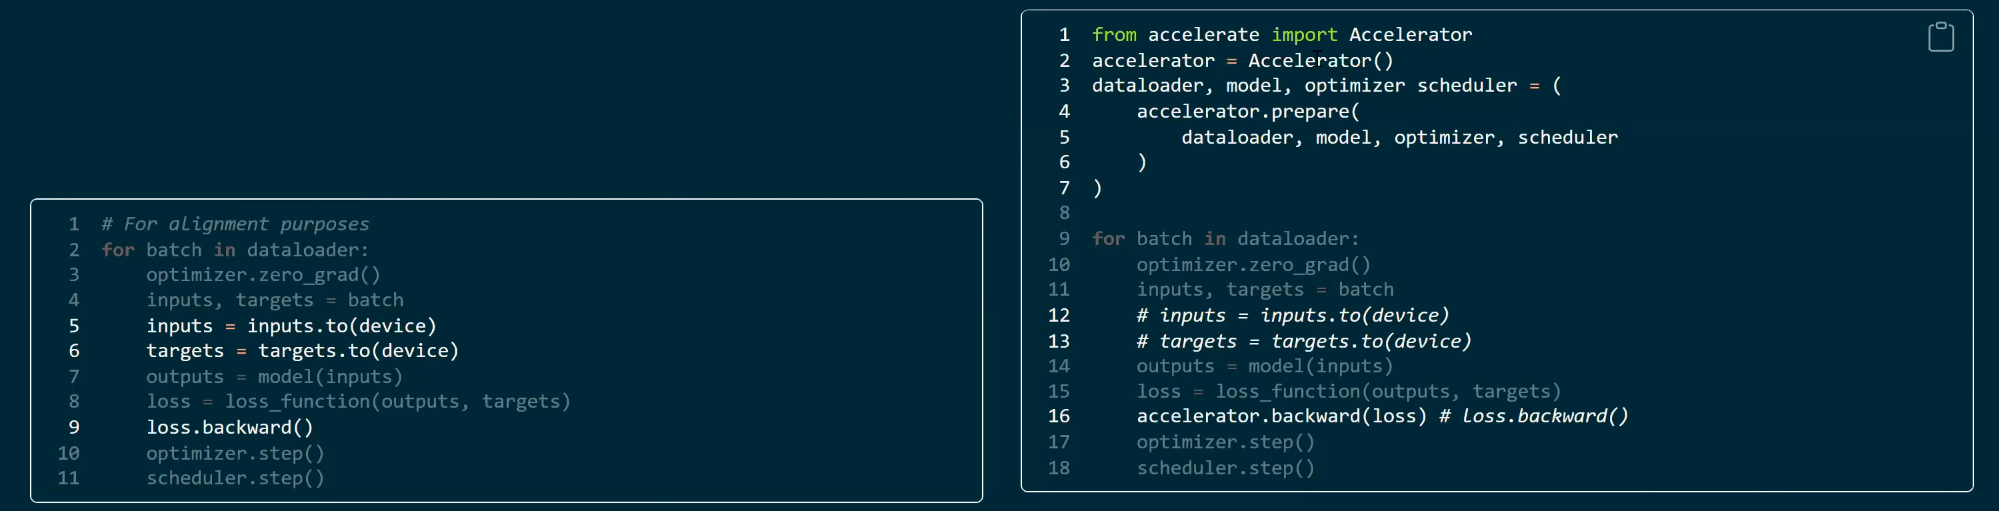

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from accelerate import Accelerator #1 Import Accelerator
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm.auto import tqdm

accelerator = Accelerator() #2 Initialize the Accelerator

dataset = load_dataset(..., split='train')
model_name = ...
tokenizer = ...
model = ...
tokenized_dataset = ...
train_dataloader = ...

#3 Prepare everything with Accelerator
model, optimizer, train_dataloader = accelerator.prepare(
    model,
    AdamW(model.parameters(), lr=5e-5),
    train_dataloader
)

#4 Training loop with accelerator.backward
model.train()
for epoch in range(1, 4):
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch}"):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss) #4
        optimizer.step()
        optimizer.zero_grad()

#### Register for checkpointing:

In [ ]:
from accelerate import Accelerator
import torch
import os

accelerator = Accelerator(project_dir="my/save/path")

my_scheduler = torch.optim.lr_scheduler.StepLR(my_optimizer, step_size=1, gamma=0.99)
my_model, my_optimizer, my_training_dataloader = accelerator.prepare(my_model, my_optimizer, my_training_dataloader)

# Register the model, optimizer, and LR scheduler for checkpointing
accelerator.register_for_checkpointing(my_model)
accelerator.register_for_checkpointing(my_optimizer)
accelerator.register_for_checkpointing(my_scheduler)

# Check if a checkpoint exists and load it
checkpoint_dir = "my/save/path/checkpointing/checkpoint_0"
if os.path.exists(checkpoint_dir):
    accelerator.load_state(checkpoint_dir)
    print(f"Loaded checkpoint from {checkpoint_dir}")
else:
    print("No checkpoint found, starting from scratch")

device = accelerator.device
my_model.to(device)

# Perform training
for epoch in range(num_epochs):
    for batch in my_training_dataloader:
        my_optimizer.zero_grad()
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = my_model(inputs)
        loss = my_loss_function(outputs, targets)
        accelerator.backward(loss)
        my_optimizer.step()
    my_scheduler.step()

    # Save checkpoint at the end of each epoch
    if accelerator.is_main_process:
        accelerator.save_state()
        print(f"Saved checkpoint at end of epoch {epoch + 1}")

# Save the final model
if accelerator.is_main_process:
    unwrapped_model = accelerator.unwrap_model(my_model)
    unwrapped_model.save_pretrained("trained_model")
    tokenizer.save_pretrained("trained_model")
accelerator.wait_for_everyone()

- Basic script is below.  Run it with `accelerate launch train.py`.

In [ ]:
import argparse
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    get_linear_schedule_with_warmup,
    AdamW,
)
from accelerate import Accelerator
from tqdm.auto import tqdm


def main():
    # Parse command-line arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--model_name", type=str, default="gpt2", help="Model name or path")
    parser.add_argument("--dataset_name", type=str, default="wikitext", help="Dataset name")
    parser.add_argument("--dataset_config", type=str, default="wikitext-2-raw-v1", help="Dataset config")
    parser.add_argument("--per_device_train_batch_size", type=int, default=4, help="Batch size per device")
    parser.add_argument("--num_train_epochs", type=int, default=1, help="Number of training epochs")
    args = parser.parse_args()

    # Initialize Accelerator
    accelerator = Accelerator()
    device = accelerator.device

    # Load the tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(args.model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token  # Set pad_token to eos_token if not already set

    model = AutoModelForCausalLM.from_pretrained(args.model_name)
    model.to(device)

    # Load and preprocess the dataset
    raw_datasets = load_dataset(args.dataset_name, args.dataset_config, split="train")

    def tokenize_function(examples):
        return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

    tokenized_datasets = raw_datasets.map(tokenize_function, batched=True, remove_columns=["text"])
    tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask"])

    # Create DataLoader
    train_dataloader = DataLoader(tokenized_datasets, shuffle=True, batch_size=args.per_device_train_batch_size)

    # Prepare optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=5e-5)
    num_update_steps_per_epoch = len(train_dataloader)
    max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=max_train_steps
    )

    # Prepare everything with Accelerator
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    # Training loop
    model.train()
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    for epoch in range(args.num_train_epochs):
        for step, batch in enumerate(train_dataloader):
            outputs = model(**batch, labels=batch["input_ids"])
            loss = outputs.loss
            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
            if step % 100 == 0 and accelerator.is_local_main_process:
                print(f"Epoch {epoch}, Step {step}, Loss: {loss.detach().item()}")

    # Save the model (only on the main process)
    if accelerator.is_main_process:
        model.save_pretrained("trained_model")
        tokenizer.save_pretrained("trained_model")


if __name__ == "__main__":
    main()

#### Using `accelerate config`:

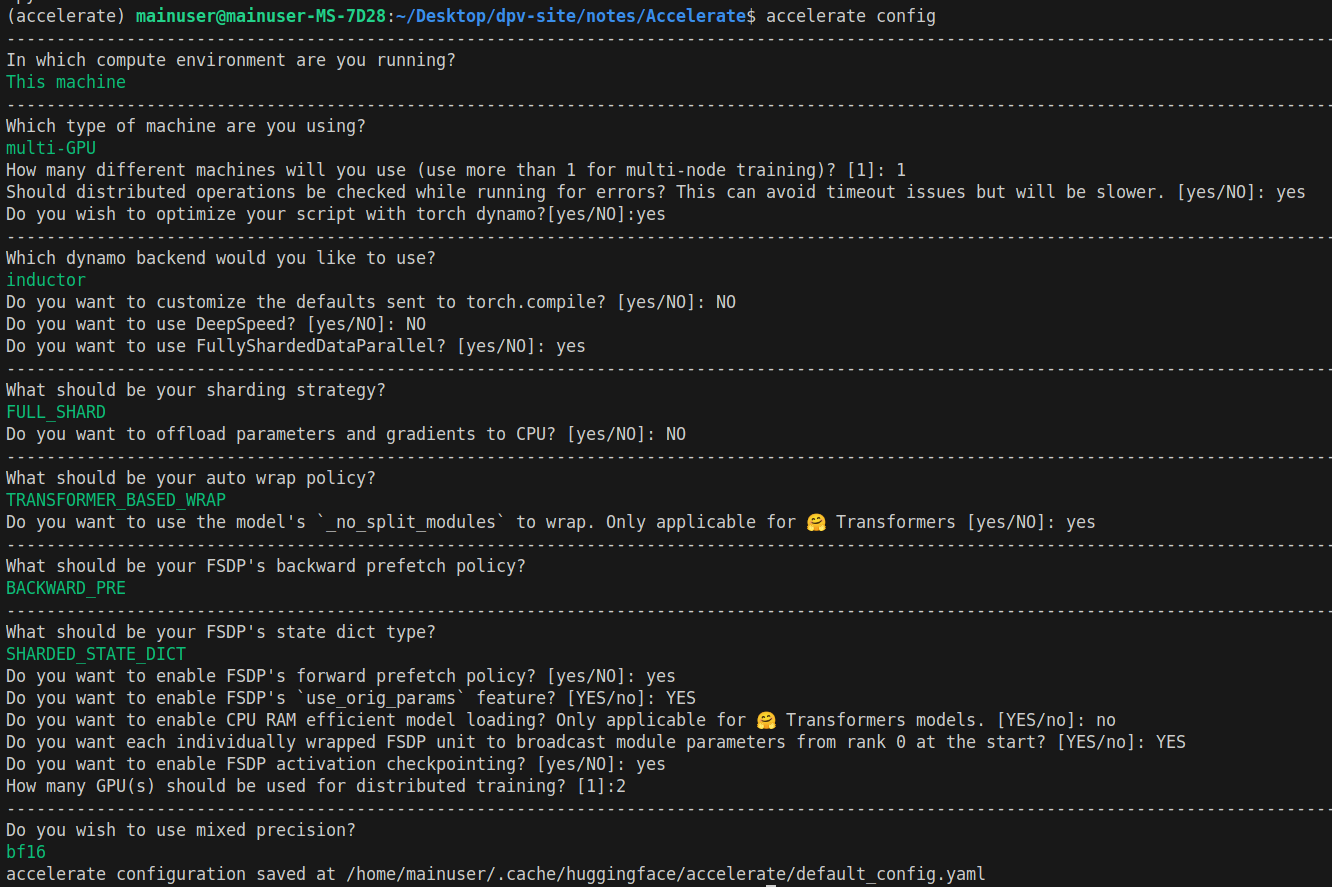

- The yaml config will end up looking as follows:

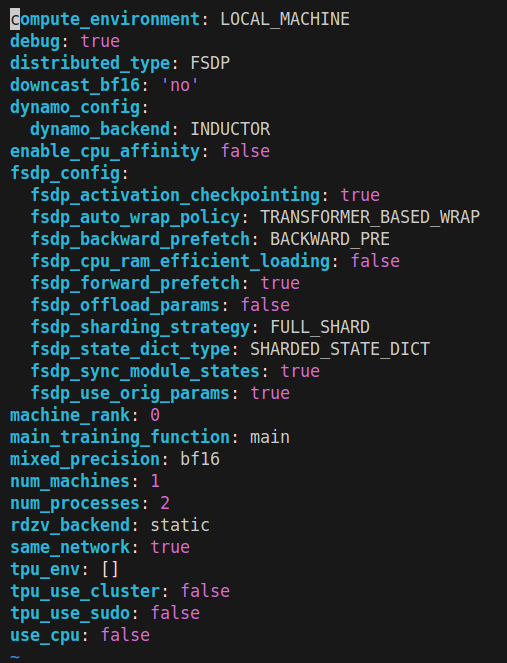

- Basic DDP vs FSDP configs, will be used by `accelerate launch`:

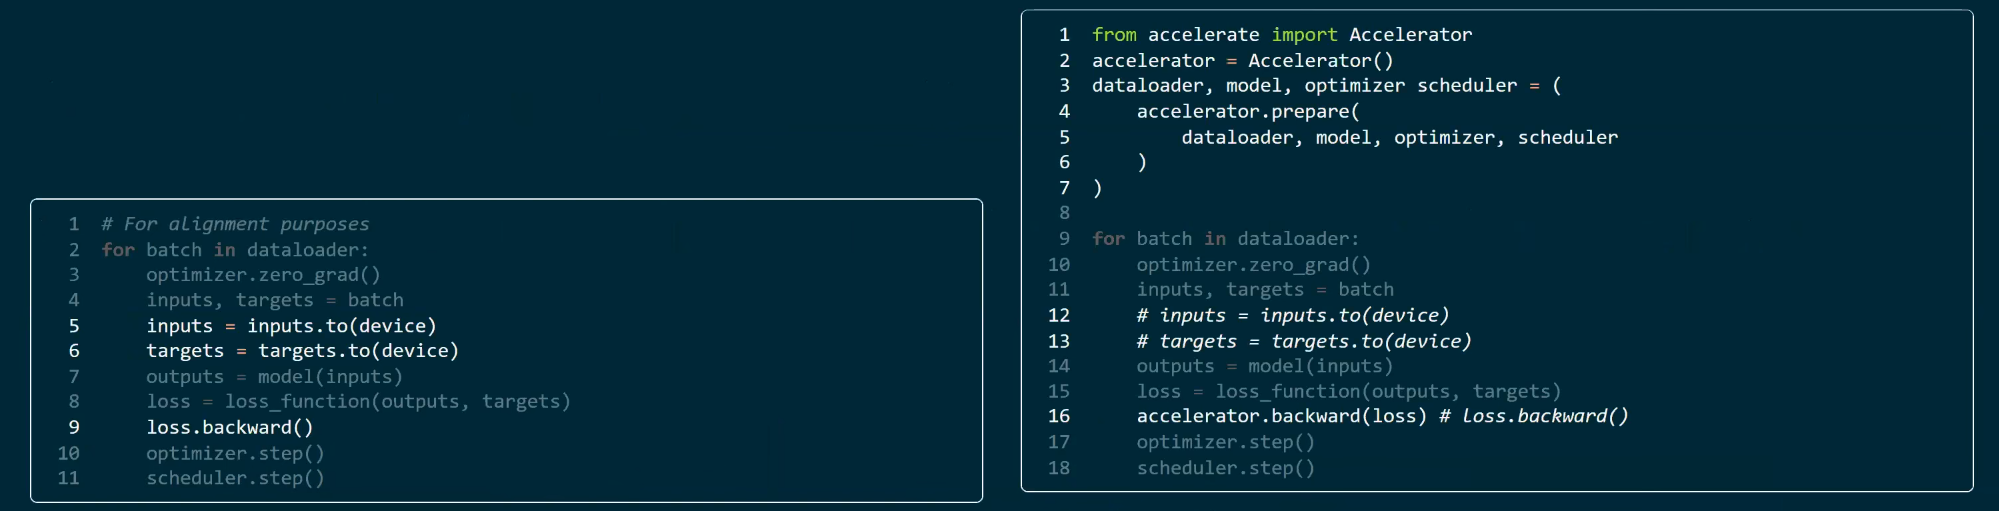

#### Logging with `accelerate`:

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator(log_with="all") # log_with='wandb'
config = {
    "num_iterations": 5,
    "learning_rate": 1e-2,
    "loss_function": str(my_loss_function),
}

accelerator.init_trackers("example_project", config=config)

my_model, my_optimizer, my_training_dataloader = accelerate.prepare(my_model, my_optimizer, my_training_dataloader)
device = accelerator.device
my_model.to(device)

for iteration in config["num_iterations"]:
    for step, batch in my_training_dataloader:
        my_optimizer.zero_grad()
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = my_model(inputs)
        loss = my_loss_function(outputs, targets)
        accelerator.backward(loss)
        my_optimizer.step()
        accelerator.log({"training_loss": loss}, step=step)
accelerator.end_training()

#### Handling CUDA Out-of-Memory with `find_executable_batch_size`

In [ ]:
def training_function(args):
    accelerator = Accelerator()

+   @find_executable_batch_size(starting_batch_size=args.batch_size)
+   def inner_training_loop(batch_size):
+       nonlocal accelerator # Ensure they can be used in our context
+       accelerator.free_memory() # Free all lingering references
        model = get_model()
        model.to(accelerator.device)
        optimizer = get_optimizer()
        train_dataloader, eval_dataloader = get_dataloaders(accelerator, batch_size)
        lr_scheduler = get_scheduler(
            optimizer, 
            num_training_steps=len(train_dataloader)*num_epochs
        )
        model, optimizer, train_dataloader, eval_dataloader, lr_scheduler = accelerator.prepare(
            model, optimizer, train_dataloader, eval_dataloader, lr_scheduler
        )
        train(model, optimizer, train_dataloader, lr_scheduler)
        validate(model, eval_dataloader)
+   inner_training_loop()

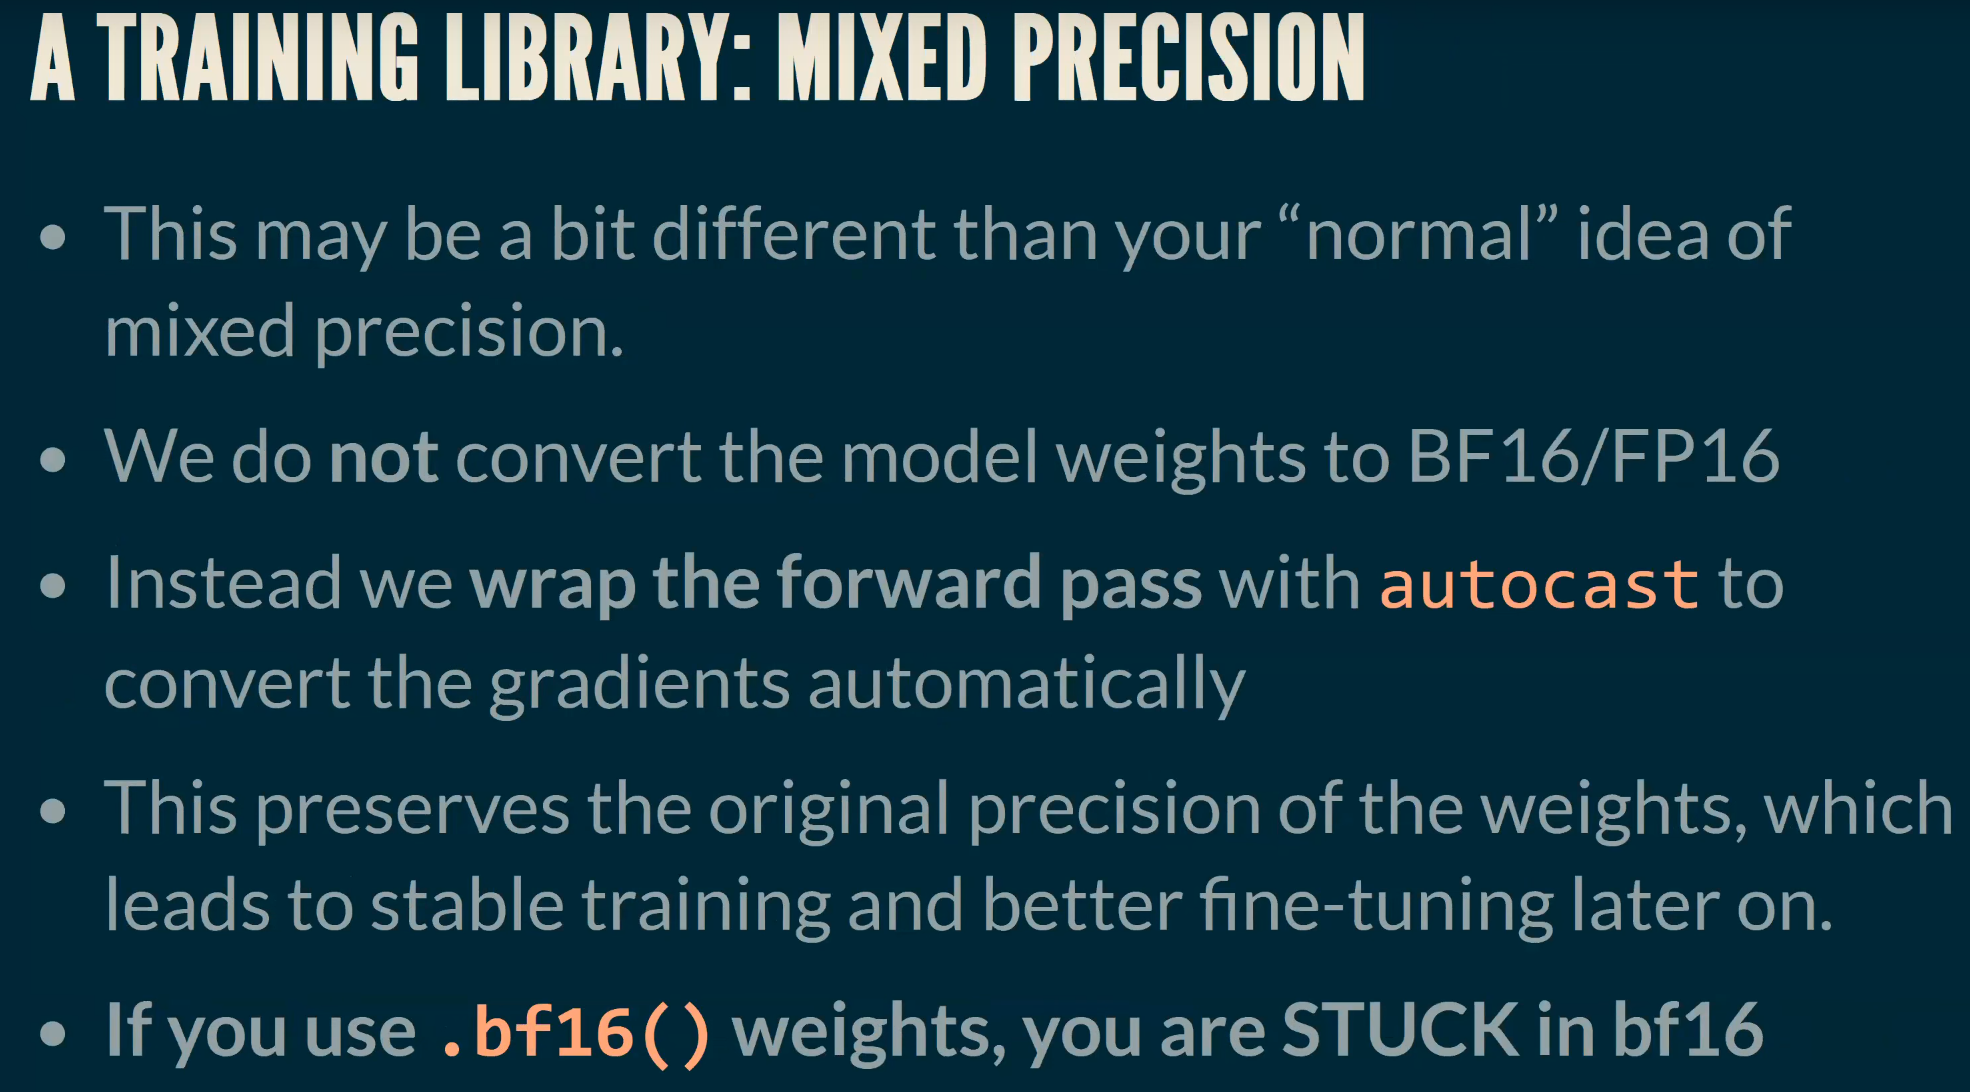

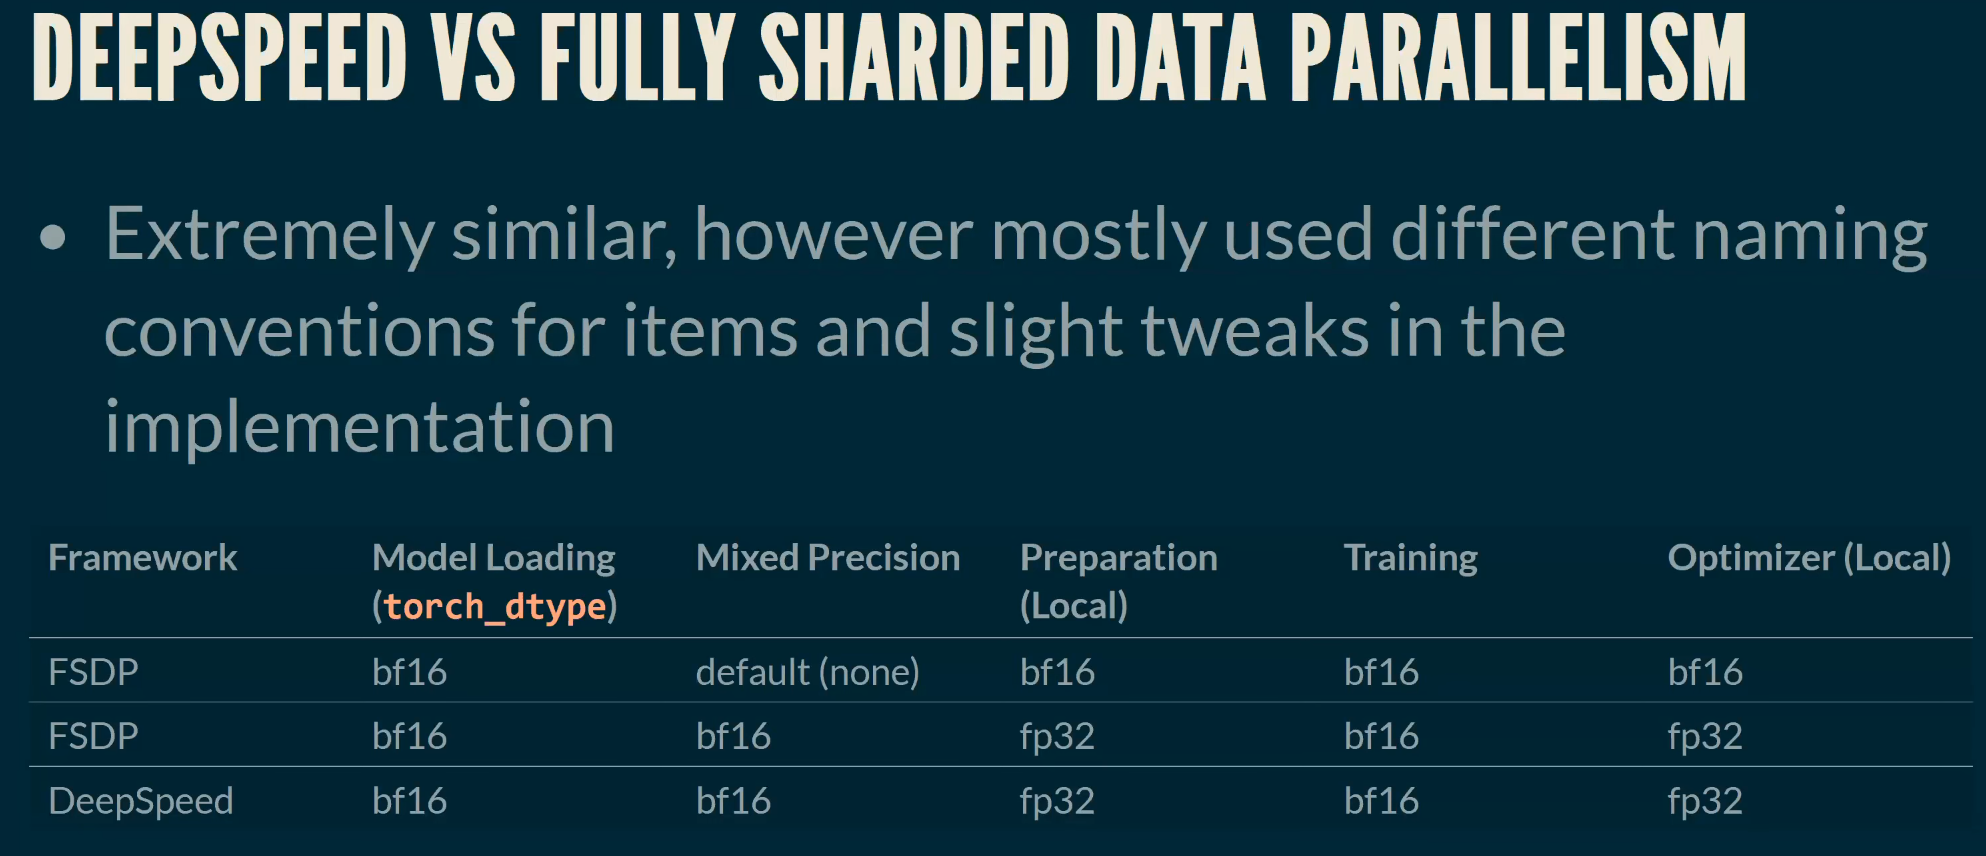